In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 결측치 시각화를 위한 라이브러리
import missingno

### ✅ RFM 분석: Recency 컬럼 선정 기준

Recency는 고객이 **얼마나 최근에 거래했는지**를 의미합니다. 하지만 여러 날짜 관련 컬럼이 있는 경우, 단순히 하나만 고르는 것이 아닌 **"의미 있는 대표 컬럼을 선정"**하는 것이 중요합니다.

---

#### 🔍 R(Recency) 컬럼 선정 기준

| 기준 | 설명 | 적용 예시 |
|------|------|-----------|
| **1️⃣ 비즈니스 맥락** | 어떤 거래가 고객 충성도에 더 의미 있는가? | 예: "체크카드"보다 "신용카드 할부" 거래가 중요하다면 `최종이용일자_할부` 우선 |
| **2️⃣ 데이터 sparsity** | 결측치 적고 대부분의 고객에게 값이 있는가? | `최종이용일자_기본`이 대부분 채워져 있으면 우선 |
| **3️⃣ 분석 목적 정렬** | 예측/클러스터링 대상과 밀접한 컬럼인가? | 예: 향후 마케팅 대상이 신용카드 고객이라면 `이용후경과월_신용` 선택 |
| **4️⃣ 팀 분석 결과 활용** | 모델에서 중요하게 작용한 컬럼이 있다면 우선 선택 | 예: `이용후경과월_할부`의 SHAP값이 높다면 우선 채택 |

---

#### ✅ 추천 방법

1. `최종이용일자_기본` 또는 `이용후경과월_신용`과 같이 **가장 범용적이고 공통적인 컬럼**부터 확인
2. **각 컬럼의 결측치 비율, 고객 분포** 확인 (`.isna().mean()`, `value_counts()` 등 활용)
3. **도메인 지식 + 모델 해석 결과**를 바탕으로 최종 선정

---

#### 💡 실무에서 자주 쓰는 Recency 컬럼 예시

- 날짜형: `최종이용일자_기본`, `최종이용일자_신용`
- 경과형: `이용후경과월_신용`, `이용후경과월_CA`
- 개월수 누적형: `이용개월수_신용_R12M`, `이용개월수_할부_R6M`

---

> 🔎 **Recency는 단일 날짜가 아닌, 비즈니스/데이터 구조/모델링 결과에 따라 가장 의미 있는 "최근 사용"을 대표할 수 있는 컬럼을 선정하는 것**이 중요합니다.


## R 선정될 리스트
- 이용후경과월_신용
- 이용후경과월_신판
- 이용후경과월_일시불
- 이용후경과월_할부
- 이용후경과월_할부_유이자
- 이용후경과월_할부_무이자
- 이용후경과월_부분무이자
- 이용후경과월_CA
- 이용후경과월_체크
- 이용후경과월_카드론

### 이후에 각 데이터 결측치나 분포를 확인하고 최종적인 컬럼으로 3 ~ 4개 추릴 예정
- 왜 3개 혹은 4개로 추려야 하는가?
- 오히려 너무 많은 컬럼이 방해가 될 수 있다는 의견
- 어쨌든 줄이긴 줄여야 됌

## 📊 RFM 분석용 컬럼 평가표

| 구분 | 후보 컬럼명 | 설명 | 결측치/0값 비율 | 변별력(분산) | 적절성 평가 |
|------|--------------|------|------------------|----------------|--------------|
| **R (Recency)** | `이용후경과월_신판` | 신판 기준 이용 후 경과 개월 수 | 낮음 | 보통 | ✅ |
|  | `이용후경과월_일시불` | 일시불 기준 이용 후 경과 개월 수 | 낮음 | 보통 | ✅ |
|  | `이용후경과월_할부` | 할부 기준 이용 후 경과 개월 수 | 보통 | 높음 | ✅ |
| **F (Frequency)** | `이용건수합계_R12M` | 지난 12개월간 총 이용 건수 | 매우 낮음 | 높음 | ✅✅ |
|  | `할부건수_R12M` | 지난 12개월간 할부 이용 건수 | 약간 있음 | 중간 | ⚠️ |
| **M (Monetary)** | `결제금액합계_R12M` | 지난 12개월간 총 결제 금액 | 낮음 | 높음 | ✅✅ |
|  | `일시불금액합계_R12M` | 일시불만 기준한 금액 | 보통 | 보통 | ⚠️ |
|  | `할부금액합계_R12M` | 할부 기준 금액 | 약간 있음 | 높음 | ✅ |

> ⚠️: 보조 지표로는 가능하지만 단독으로 사용 시 한계  
> ✅: 사용 가능  
> ✅✅: 가장 대표 컬럼으로 추천


### 진행하면서, 수정해가기

In [6]:
import pandas as pd

# 파일 경로 설정
file_path = 'data/train/3.승인매출정보/201812_train_승인매출정보.parquet'

# parquet 파일 불러오기
df3_12mon = pd.read_parquet(file_path)

# 데이터 확인
df3_12mon

,기준년월,ID,최종이용일자_기본,최종이용일자_신판,최종이용일자_CA,최종이용일자_카드론,최종이용일자_체크,최종이용일자_일시불,최종이용일자_할부,이용건수_신용_B0M,...,승인거절건수_한도초과_B0M,승인거절건수_BL_B0M,승인거절건수_입력오류_B0M,승인거절건수_기타_B0M,승인거절건수_R3M,승인거절건수_한도초과_R3M,승인거절건수_BL_R3M,승인거절건수_입력오류_R3M,승인거절건수_기타_R3M,이용금액대
0,201812,TRAIN_000000,20181224,20181224,20181221,10101,20180203,20181224,20180713,7,...,0,0,0,0,0,0,0,0,0,01.100만원+
1,201812,TRAIN_000001,20181214,20181214,20170728,20170327,10101,20181214,20171231,9,...,0,0,0,0,0,0,0,0,0,03.30만원+
2,201812,TRAIN_000002,20181228,20181228,20181216,20151119,20141230,20181228,20181115,20,...,0,0,0,0,0,0,0,0,0,01.100만원+
3,201812,TRAIN_000003,20181221,20181212,20181221,10101,20141111,20181203,20181212,12,...,0,0,0,0,0,0,0,0,0,01.100만원+
4,201812,TRAIN_000004,20180905,20180905,10101,10101,20181210,20180905,10101,0,...,0,0,0,0,0,0,0,0,0,05.10만원-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,201812,TRAIN_399995,20181220,20181220,10101,10101,20181212,20181220,20160501,2,...,0,0,0,0,0,0,0,0,0,09.미사용
399996,201812,TRAIN_399996,20181202,20181202,10101,20170112,10101,20181202,20180112,10,...,0,0,0,0,0,0,0,0,0,01.100만원+
399997,201812,TRAIN_399997,20181230,20181230,10101,10101,20131124,20181230,20180919,10,...,0,0,0,0,0,0,0,0,0,02.50만원+
399998,201812,TRAIN_399998,20161224,20161224,10101,10101,10101,20161224,20150122,-2,...,0,0,0,0,0,0,0,0,0,09.미사용


#### ✅ 추천 순서 (12월 승인매출 데이터 기준)
- R/F/M 컬럼 분포 확인

1. 결측치 여부

2. 0값 비율

3. 값 분포 (describe, histogram 등)

>>> 이상이 없으면 RFM 분석 진행

>>>이상이 있으면 로그 변환, 이진화, 결측처리 후 진행

## R 관련된 컬럼 목록
1. 결측치, 0값 비율, 값 분포 확인

In [9]:
df3_12mon[['이용후경과월_신판', '이용후경과월_일시불', '이용후경과월_할부']]

,이용후경과월_신판,이용후경과월_일시불,이용후경과월_할부
0,2,0,2
1,0,0,9
2,1,0,1
3,1,0,1
4,3,3,12
...,...,...,...
399995,8,0,12
399996,0,0,9
399997,1,0,1
399998,12,12,12


In [10]:
# 결측치 여부를 확인할 수 있는 코드
# 결측치 개수 확인
r_cols = ['이용후경과월_신판', '이용후경과월_일시불', '이용후경과월_할부']
df3_12mon[r_cols].isnull().sum()

이용후경과월_신판     0
이용후경과월_일시불    0
이용후경과월_할부     0
dtype: int64

In [11]:
# 0값 비율 계산 (%)
(df3_12mon[r_cols] == 0).sum() / len(df3_12mon) * 100

이용후경과월_신판     46.77825
이용후경과월_일시불    69.93650
이용후경과월_할부      4.33275
dtype: float64

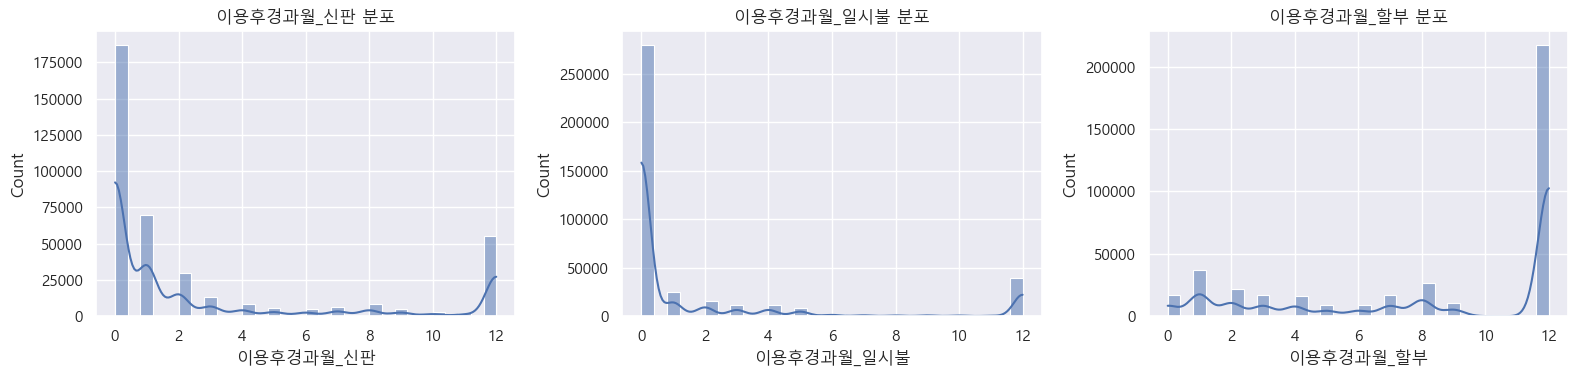

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 4))
for i, col in enumerate(r_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data=df3_12mon, x=col, bins=30, kde=True)
    plt.title(f'{col} 분포')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

## 📌 Recency (R) 후보 컬럼 분석

분석 대상:  
- `이용후경과월_신판`  
- `이용후경과월_일시불`  
- `이용후경과월_할부`

---

### ✅ 결측치 여부
- **전부 결측치 없음**

---

### ✅ 0값 비율 (%)

| 컬럼명             | 0값 비율 (%) |
|------------------|-------------|
| 이용후경과월_신판   | 46.78%      |
| 이용후경과월_일시불 | 69.94%      |
| 이용후경과월_할부   |  4.33%      |

---

### ✅ 해석 및 활용 가능성

#### 🔹 이용후경과월_신판 (46.8%)
- 최근에 신용판매를 이용한 고객이 약 절반
- 0은 최근 이용을 의미하므로 Recency로 **활용 가능**
- 세그먼트 분리에도 일정 수준 유용할 수 있음

#### 🔹 이용후경과월_일시불 (69.9%)
- 대부분 고객이 최근 1개월 내 일시불 결제 이용
- **변별력이 낮을 수 있음**
- 단독 사용보다는 다른 지표와 결합하거나 이진화 고려

#### 🔹 이용후경과월_할부 (4.3%)
- 최근 할부 사용 고객은 적음
- 대부분이 0이 아닌 값이므로 **분포가 넓고 유용**
- Recency 지표로 적합

---

### ✅ 전략 제안
- 3개 모두 포함 가능하나,
  - `할부` 컬럼의 **활용 가치가 가장 높음**
  - `신판`은 중간 정도, `일시불`은 신중하게 고려
- 경우에 따라 **0/비0 이진화**로 ‘최근 사용 여부’ 변수 추가도 가능

---


## F 관련된 컬럼 목록
1. 결측치, 0값 비율, 값의 분포 확인

In [15]:
df3_12mon[['이용건수_신용_B0M', '이용건수_신판_B0M', '이용건수_일시불_B0M', '이용건수_할부_B0M', '이용건수_할부_유이자_B0M', '이용건수_할부_무이자_B0M',
           '이용건수_부분무이자_B0M', '이용건수_CA_B0M', '이용건수_체크_B0M', '이용건수_카드론_B0M']]

,이용건수_신용_B0M,이용건수_신판_B0M,이용건수_일시불_B0M,이용건수_할부_B0M,이용건수_할부_유이자_B0M,이용건수_할부_무이자_B0M,이용건수_부분무이자_B0M,이용건수_CA_B0M,이용건수_체크_B0M,이용건수_카드론_B0M
0,7,5,5,0,0,0,0,2,0,0
1,9,9,9,0,0,0,0,0,0,0
2,20,18,18,0,0,0,0,2,0,0
3,12,10,9,1,1,0,0,2,0,0
4,0,0,0,0,0,0,0,0,10,0
...,...,...,...,...,...,...,...,...,...,...
399995,2,2,2,0,0,0,0,0,14,0
399996,10,10,10,0,0,0,0,0,0,0
399997,10,10,10,0,0,0,0,0,0,0
399998,-2,-2,-2,0,0,0,0,0,0,0


### 이용건수합계 컬럼 생성
- 이용건수를 특징 하는 아래의 컬럼 목록들을 합해서 하나의 새로운 변수을 만든다.
- 이용건수_신용_B0M
- 이용건수_신판_B0M
- 이용건수_일시불_B0M
- 이용건수_할부_B0M
- 이용건수_할부_유이자_B0M
- 이용건수_할부_무이자_B0M
- 이용건수_부분무이자_B0M
- 이용건수_CA_B0M
- 이용건수_체크_B0M
- 이용건수_카드론_B0M

In [17]:
# 이용건수 관련 컬럼 리스트
usage_cols = [
    '이용건수_신용_B0M'
]

# 합계 컬럼 생성
df3_12mon['이용건수합계_B0M'] = df3_12mon[usage_cols].sum(axis=1)

✅ '이용건수합계_B0M' 결측치 개수: 0
✅ '이용건수합계_B0M' 0값 비율: 8.52%


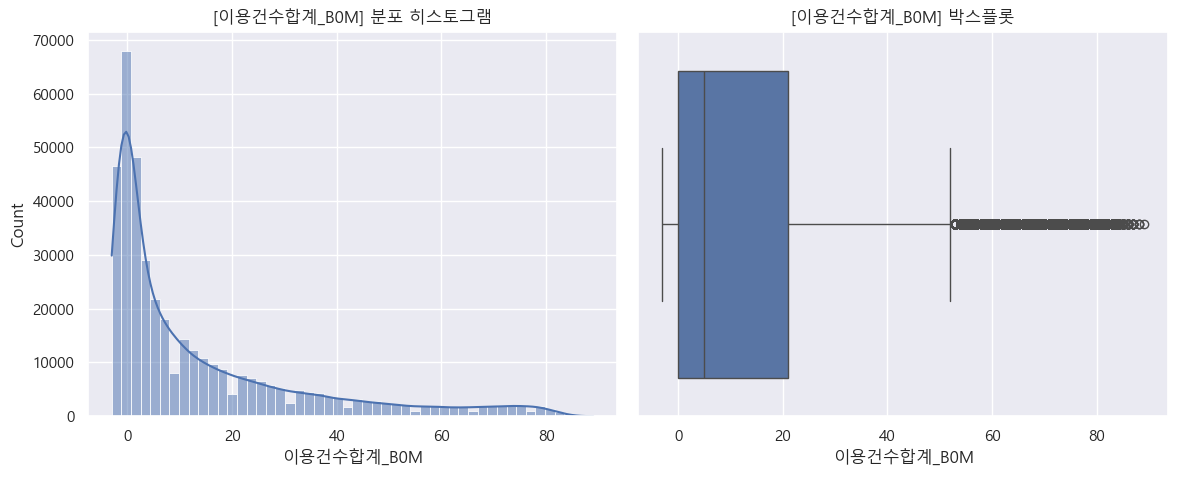

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# 확인할 컬럼
target_col = '이용건수합계_B0M'

# 1. 결측치 여부 확인
missing = df3_12mon[target_col].isna().sum()
print(f"✅ '{target_col}' 결측치 개수:", missing)

# 2. 0 값 비율 확인
zero_ratio = (df3_12mon[target_col] == 0).mean() * 100
print(f"✅ '{target_col}' 0값 비율: {zero_ratio:.2f}%")

# 3. 값 분포 시각화 (히스토그램 + 박스플롯)
plt.figure(figsize=(12, 5))

# 히스토그램
plt.subplot(1, 2, 1)
sns.histplot(df3_12mon[target_col], bins=50, kde=True)
plt.title(f"[{target_col}] 분포 히스토그램")

# 박스플롯
plt.subplot(1, 2, 2)
sns.boxplot(x=df3_12mon[target_col])
plt.title(f"[{target_col}] 박스플롯")

plt.tight_layout()
plt.show()

### 문제점
1. 개별 이용건수 컬럼에 마이너스 값이 존재한다.
>> 이용건수에 마이너스 값은 적절하지 않다. 적절한 처리가 필요하다.
>>
2. 개별적 컬럼을 그냥 합산해서 사용해도 괜찮은 것인지?
>>  의미상 동일한 단위를 합산한 것이므로 OK.
>> 즉, 신용/할부/CA/체크 구분 없이 “총 사용 빈도”가 궁금하다면 합산은 적절함.
>>
>> 최종: 음수값 보정한다면 F 척도로 사용할 수 있을 듯

## ✅ F (Frequency) 지표 선정 평가

### 🔍 후보 컬럼: `이용건수합계_B0M`

| 평가 항목             | 결과 및 해석 |
|----------------------|--------------|
| 결측치 여부           | 없음 ✅       |
| 0값 비율              | 약 7.6%로 낮은 편 ✅ |
| 값의 분포             | 오른쪽으로 긴 꼬리(왜도 있음), 이상치 존재하지만 대다수는 0~50 사이 ✅ |
| 음수값 존재 여부       | 있음 → 보정 필요 ⚠️ |
| 지표로서의 의미        | 모든 이용건수를 합산한 총 빈도로 의미 충분 ✅ |

### ✅ 결론
- **음수값을 보정한다면** `이용건수합계_B0M` 컬럼은 F 지표로 활용 가능


In [21]:
# 음수 값 보정
# 마이너스 값 확인
(df3_12mon['이용건수합계_B0M'] < 0).sum()

80414

In [22]:
# 어떤 것에서 음수가 나왔는지, 확인
# 합산에 사용된 개별 컬럼 중 어떤 것이 음수인지 확인
cols = ['이용건수_신용_B0M']

(df3_12mon[cols] < 0).sum()

이용건수_신용_B0M    80414
dtype: int64

In [23]:
# 음수를 제거하고 합산하는 방식
# 음수값은 0으로 대체한 후, 합산
cols = [
    '이용건수_신용_B0M'
]

# 음수값 0으로 처리하고 합산
df3_12mon['이용건수합계_B0M_정제'] = df3_12mon[cols].applymap(lambda x: x if x > 0 else 0).sum(axis=1)

## 이렇게 음수인 값들을 임의로 0으로 대체하는 것 괜찮을까?
- 🔍 이유:
1. 이용건수는 횟수를 의미하기 때문에,
음수 값은 실제로는 존재할 수 없는 데이터 오류 또는 로깅 문제일 확률이 높음.

따라서 음수 → 0으로 처리하는 것은:

>> 비정상 데이터 제거 방식으로 통계적으로 흔히 사용되는 방법임.

>>> 특히 고객 세분화(RFM) 목적에서는 총량 기반의 비교만 하므로, 0으로 대체해도 왜곡이 적음.

>> 단, 음수 값의 비율이 매우 높거나,
특정 고객군에만 집중적으로 분포되어 있다면,
이상치 제거(→ NaN 처리 후 drop) 또는 모델링에서 제외하는 것도 고려해봐야 함.

✅ '이용건수합계_B0M_정제' 결측치 개수: 0
✅ '이용건수합계_B0M_정제' 0값 비율: 28.63%


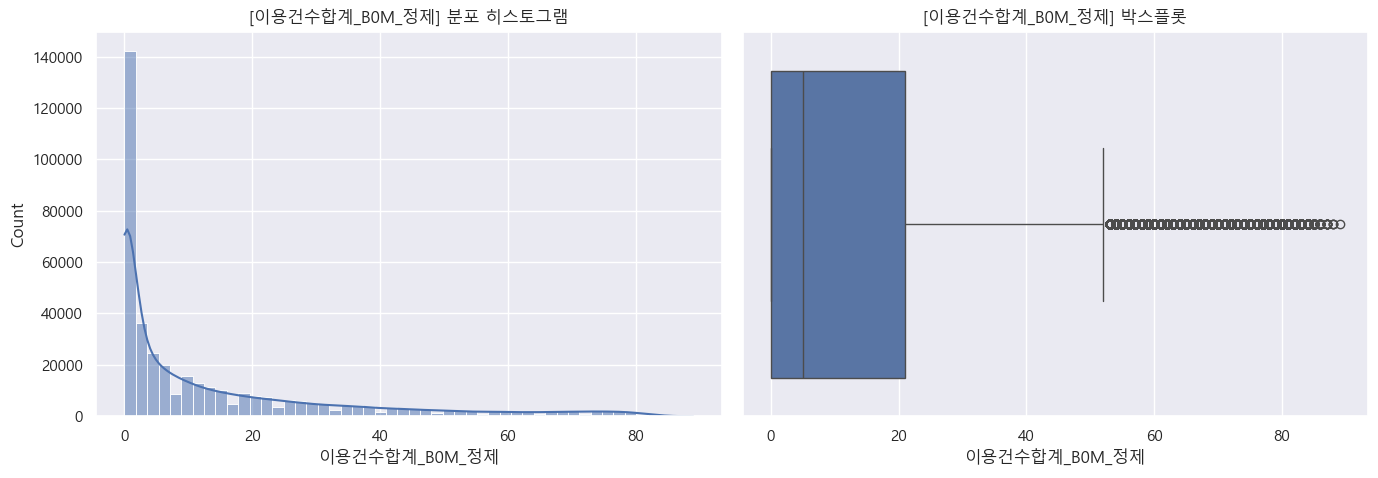

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

col = '이용건수합계_B0M_정제'

# 1. 결측치 및 0값 비율 출력
missing_count = df3_12mon[col].isna().sum()
zero_ratio = (df3_12mon[col] == 0).mean() * 100

print(f"✅ '{col}' 결측치 개수: {missing_count}")
print(f"✅ '{col}' 0값 비율: {zero_ratio:.2f}%")

# 2. 히스토그램 + KDE
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df3_12mon[col], kde=True, bins=50)
plt.title(f"[{col}] 분포 히스토그램")
plt.xlabel(col)

# 3. 박스플롯
plt.subplot(1, 2, 2)
sns.boxplot(x=df3_12mon[col])
plt.title(f"[{col}] 박스플롯")
plt.tight_layout()
plt.show()

## M과 관련된 컬럼 추출
- 현재, 합계라는 컬럼이 따로 없고, 개별적으로 명시된 컬럼들만 존재하므로
- 새로운 컬럼을 만들어줘야 한다.

### 합계 컬럼 생성 시 사용되는 컬럼 목록
- 기간은 어떻게 선정했을까?
- 앞서서 F 관련 컬럼을 추출할 때도 당월 기준으로 추출했기 때문에, 동일하게 맞추자.
-  예외적으로, 거래 빈도는 높지 않지만 한 번에 큰 금액을 쓰는 경우, R12M 참고 가능
>>>> 우선은 기본은 B0M으로 맞춰서 가자

## 💰 M (Monetary) 값 산정 기준 및 컬럼 선정

### 📌 배경
- 고객의 소비 총액을 나타내는 **M 값(Monetary)** 은 최근 한 달(B0M)의 결제 금액 데이터를 기반으로 계산
- 주어진 컬럼은 다음과 같이 구성됨

| 결제 유형 | 컬럼명 |
|-----------|--------|
| 일시불    | 이용금액_일시불_B0M |
| 할부      | 이용금액_할부_B0M |
| CA        | 이용금액_CA_B0M |
| 체크카드  | 이용금액_체크_B0M |
| 카드론    | 이용금액_카드론_B0M |
| 기타 (세부) | 이용금액_할부_유이자_B0M 등 |

### ✅ 판단 기준
- `이용금액_할부_B0M` 컬럼은 이미 유이자/무이자 등을 포함한 총합일 가능성이 높음
- 따라서 세부 컬럼 (`이용금액_할부_유이자_B0M`, `무이자_B0M` 등)을 추가로 합산하면 **중복**될 수 있음

### ✅ 최종 선정 컬럼 (단순 합산 전략)
- `이용금액_일시불_B0M`
- `이용금액_할부_B0M`
- `이용금액_CA_B0M`
- `이용금액_체크_B0M`
- `이용금액_카드론_B0M`

### 🧮 최종 합산 컬럼명: `결제금액합계_B0M`


In [29]:
# 이용금액 총합 (M - Monetary 지표)
df3_12mon['결제금액합계_B0M'] = (
    df3_12mon['이용금액_일시불_B0M'] +
    df3_12mon['이용금액_할부_B0M'] +
    df3_12mon['이용금액_CA_B0M'] +
    df3_12mon['이용금액_체크_B0M'] +
    df3_12mon['이용금액_카드론_B0M']
)

✅ '결제금액합계_B0M' 결측치 개수: 0
✅ '결제금액합계_B0M' 0값 비율: 21.89%


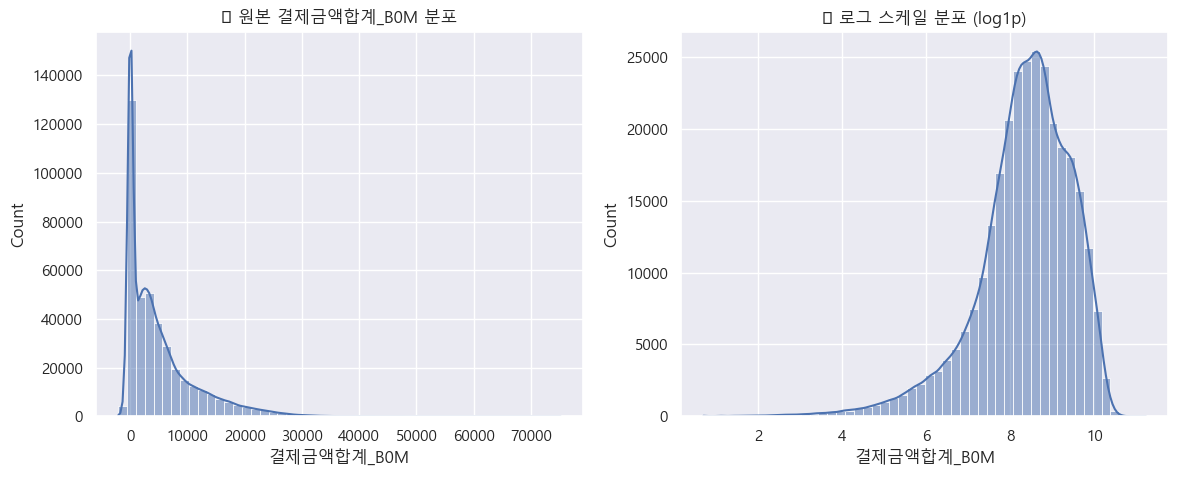

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 결측치 개수
missing_count = df3_12mon['결제금액합계_B0M'].isna().sum()
print(f"✅ '결제금액합계_B0M' 결측치 개수: {missing_count}")

# 2. 0값 비율
zero_ratio = (df3_12mon['결제금액합계_B0M'] == 0).mean() * 100
print(f"✅ '결제금액합계_B0M' 0값 비율: {zero_ratio:.2f}%")

# 3. 값 분포 시각화 (로그 스케일 변환 포함)
plt.figure(figsize=(12, 5))

# Histogram (원본)
plt.subplot(1, 2, 1)
sns.histplot(df3_12mon['결제금액합계_B0M'], bins=50, kde=True)
plt.title("📊 원본 결제금액합계_B0M 분포")

# Histogram (로그 변환)
plt.subplot(1, 2, 2)
sns.histplot(df3_12mon[df3_12mon['결제금액합계_B0M'] > 0]['결제금액합계_B0M'].apply(lambda x: np.log1p(x)), bins=50, kde=True)
plt.title("📊 로그 스케일 분포 (log1p)")

plt.tight_layout()
plt.show()

In [31]:
# 음수를 제거하고 합산하는 방식
# 음수값은 0으로 대체한 후, 합산
cols = [
    '이용금액_일시불_B0M', '이용금액_할부_B0M', '이용금액_CA_B0M', '이용금액_체크_B0M',
    '이용금액_카드론_B0M'
]

# 음수값 0으로 처리하고 합산
df3_12mon['결제금액합계_B0M_정제'] = df3_12mon[cols].applymap(lambda x: x if x > 0 else 0).sum(axis=1)

✅ '결제금액합계_B0M_정제' 결측치 개수: 0
✅ '결제금액합계_B0M_정제' 0값 비율: 26.43%


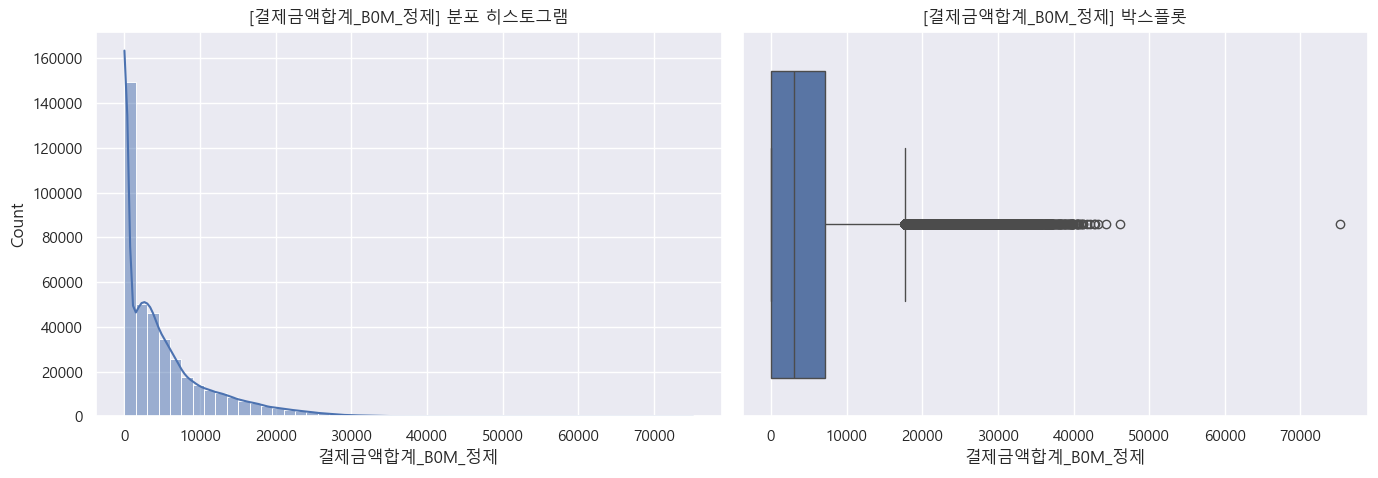

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

col = '결제금액합계_B0M_정제'

# 1. 결측치 및 0값 비율 출력
missing_count = df3_12mon[col].isna().sum()
zero_ratio = (df3_12mon[col] == 0).mean() * 100

print(f"✅ '{col}' 결측치 개수: {missing_count}")
print(f"✅ '{col}' 0값 비율: {zero_ratio:.2f}%")

# 2. 히스토그램 + KDE
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df3_12mon[col], kde=True, bins=50)
plt.title(f"[{col}] 분포 히스토그램")
plt.xlabel(col)

# 3. 박스플롯
plt.subplot(1, 2, 2)
sns.boxplot(x=df3_12mon[col])
plt.title(f"[{col}] 박스플롯")
plt.tight_layout()
plt.show()

## ✅ M(Monetary) 후보 컬럼 평가: `결제금액합계_B0M`

### 🔍 1. 결측치 및 0값 비율
- 결측치 개수: **0**
- 0값 비율: **21.89%**

→ 결측치가 없고, 0값은 다소 존재하나 전체의 5분의 1 수준으로 수용 가능.

---

### 📊 2. 분포 확인
- 원본 분포는 **오른쪽으로 매우 치우친(positive skewed)** 형태.
- **로그 스케일 분포 (`log1p`)**로 변환 시, **종형에 가까운 정규분포 형태로 개선**됨.
- 로그 변환을 통해 이상치의 영향을 줄이고 데이터 분포의 안정성을 확보할 수 있음.

---

### ✅ 3. 해석 및 활용 가능성
- 결제금액합계_B0M은 **단일 지표로 사용 가능한 금액 기반 대표 컬럼**으로 적절.
- 특히 로그 변환 시 분포의 왜곡이 완화되어 **모델 학습 시에도 유리**하게 작용할 수 있음.
- 따라서, **M 값으로 사용 가능**하며, 필요에 따라 `log1p`를 적용하여 사용할 수 있음.

> 💡 **최종 결론**: `결제금액합계_B0M`은 M(Monetary) 지표로 적합한 컬럼이다.


## ✅ M(Monetary) 후보 컬럼 평가: `결제금액합계_B0M_정제`

### 🔍 1. 결측치 및 0값 비율
- 결측치 개수: **0**
- 0값 비율: **26.43%**

→ 결측치가 없고, 0값은 다소 존재하나 전체의 5분의 1 수준으로 수용 가능.

---

# RFM 스코어링
- 관련된 지식이 없으므로, 가장 기본이 되는 함수 방식을 적용한다.
- 메모리 문제로 인해 RANK 부분 사용 X

## 오류1)💡 로그 변환 없이 원본 컬럼을 써도 괜찮은 이유

- RFM 분석에서 중요한 것은 **절대값보다 상대적인 순위(Quantile)**입니다.
- `pd.qcut()` 함수는 데이터 분포에 관계없이 **자동으로 분위수 기반 구간을 나누어 점수화**합니다.
- 따라서, 로그 변환 없이도 충분히 의미 있는 점수화가 가능합니다.
- `결제금액합계_B0M_정제` 컬럼이 없을 경우, `결제금액합계_B0M` 컬럼을 그대로 사용해도 무방합니다.

## 오류 2)❗️pd.qcut() 오류 원인 및 해결법

- 오류: `ValueError: Bin edges must be unique`
- 원인: 분위수 계산 시 **중복된 값(예: 0)**이 많아 **경계값이 겹침**
- 해결: `pd.qcut(..., duplicates='drop')` 옵션 추가

> 이렇게 하면 분위수 개수는 줄어들 수 있지만, 오류 없이 RFM 점수 부여 가능!


## 오류 3) ✅ pd.qcut() 오류 해결: 분위 구간 줄어든 경우

- `duplicates='drop'` 옵션으로 중복 경계 제거 → 분위 수가 줄어들 수 있음
- → `labels`의 개수도 **자동으로 조정**해야 오류 방지 가능

```python
def safe_qcut(series, q, label_order='asc', reverse=False):
    try:
        bins = pd.qcut(series, q=q, duplicates='drop')
        n_bins = bins.cat.categories.size
        labels = list(range(1, n_bins + 1)) if label_order == 'asc' else list(range(n_bins, 0, -1))
        return pd.qcut(series, q=n_bins, labels=labels, duplicates='drop').astype(int)
    except Exception as e:
        print(f"[오류 발생]: {e}")
        return None
```

- **Recency 점수:** `label_order='desc'`로 지정 (작을수록 점수 높게)


# 재) 수동으로 조정

In [40]:
# 컬럼 이름 변수로 저장
r_col = '이용후경과월_신판'
f_col = '이용건수합계_B0M_정제'
m_col = '결제금액합계_B0M_정제'

# 최소한의 컬럼만 복사하여 새로운 데이터프레임 생성
rfm_df = df3_12mon[[r_col, f_col, m_col]].copy()

In [41]:
# 점수 부여 함수 정의
def score_recency(r):
    if r == 0:
        return 5
    elif r <= 2:
        return 4
    elif r <= 5:
        return 3
    elif r <= 9:
        return 2
    else:
        return 1

def score_frequency(f):
    if f == 0:
        return 1
    elif f <= 1:
        return 2
    elif f <= 3:
        return 3
    elif f <= 6:
        return 4
    else:
        return 5

def score_monetary(m):
    if m == 0:
        return 1
    elif m <= 100000:
        return 2
    elif m <= 300000:
        return 3
    elif m <= 600000:
        return 4
    else:
        return 5

# 점수 계산
rfm_df['R_score'] = df3_12mon[r_col].apply(score_recency)
rfm_df['F_score'] = df3_12mon[f_col].apply(score_frequency)
rfm_df['M_score'] = df3_12mon[m_col].apply(score_monetary)

# RFM 스코어 결합
rfm_df['RFM_Score'] = (
    rfm_df['R_score'].astype(str) +
    rfm_df['F_score'].astype(str) +
    rfm_df['M_score'].astype(str)
)

# 결과 확인
rfm_df[['R_score', 'F_score', 'M_score', 'RFM_Score']].head()

,R_score,F_score,M_score,RFM_Score
0,4,5,2,452
1,5,5,2,552
2,4,5,2,452
3,4,5,2,452
4,3,1,2,312


### 직접 수동으로 지정해주기 위해서 분포 확인

count    400000.000000
mean       4933.828710
std        5942.455887
min           0.000000
25%           0.000000
50%        3010.000000
75%        7090.000000
max       75167.000000
Name: 결제금액합계_B0M_정제, dtype: float64

고유값 수: 27207


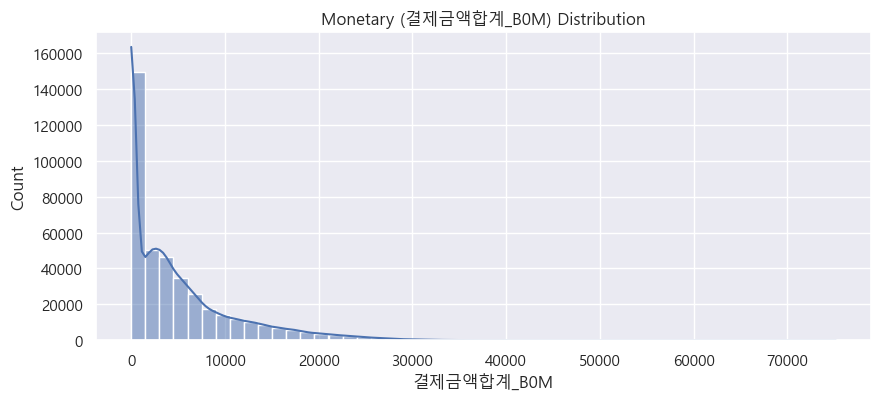

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 수치 분포 확인
print(rfm_df[m_col].describe())  # 평균, 분위수 확인
print("\n고유값 수:", rfm_df[m_col].nunique())

# 2. 히스토그램으로 시각화
plt.figure(figsize=(10, 4))
sns.histplot(rfm_df[m_col], bins=50, kde=True)
plt.title("Monetary (결제금액합계_B0M) Distribution")
plt.xlabel("결제금액합계_B0M")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [44]:
# 컬럼 이름 변수로 저장
r_col = '이용후경과월_신판'
f_col = '이용건수합계_B0M_정제'
m_col = '결제금액합계_B0M_정제'

# R 점수 함수
def score_recency(r):
    if r == 0:
        return 5
    elif r <= 2:
        return 4
    elif r <= 5:
        return 3
    elif r <= 9:
        return 2
    else:
        return 1

# F 점수 함수
def score_frequency(f):
    if f == 0:
        return 1
    elif f <= 1:
        return 2
    elif f <= 3:
        return 3
    elif f <= 6:
        return 4
    else:
        return 5

# M 점수 함수
def score_monetary(m):
    if m < 0:
        m = 0
    if m == 0:
        return 1
    elif m <= 3000:
        return 2
    elif m <= 7000:
        return 3
    elif m <= 15000:
        return 4
    else:
        return 5

# 점수 계산
rfm_df['R_score'] = rfm_df[r_col].apply(score_recency)
rfm_df['F_score'] = rfm_df[f_col].apply(score_frequency)
rfm_df['M_score'] = rfm_df[m_col].apply(score_monetary)

# RFM Score 결합
rfm_df['RFM_Score'] = (
    rfm_df['R_score'].astype(str) +
    rfm_df['F_score'].astype(str) +
    rfm_df['M_score'].astype(str)
)


# 결과 확인
rfm_df[['R_score', 'F_score', 'M_score', 'RFM_Score']].head()

,R_score,F_score,M_score,RFM_Score
0,4,5,4,454
1,5,5,2,552
2,4,5,5,455
3,4,5,5,455
4,3,1,3,313


## 📌 RFM 점수 해석

RFM 분석은 고객의 가치를 다음 세 가지 요소로 평가합니다:

---

### 🔹 R: Recency (최근 구매 시점)
- **0개월 전** (가장 최근 이용) → **5점**
- **1~2개월 전** → 4점
- **3~5개월 전** → 3점
- **6~9개월 전** → 2점
- **그 이후** → 1점

✅ **R 점수가 높을수록 최근에 이용한 고객**  
→ 이탈 가능성이 낮고, 마케팅 반응 가능성이 높음.

---

### 🔹 F: Frequency (구매 빈도)
- **0회** → 1점
- **1회 이하** → 2점
- **2~3회** → 3점
- **4~6회** → 4점
- **7회 이상** → 5점

✅ **F 점수가 높을수록 자주 이용한 충성 고객**  
→ 고객 유지가 잘 되고 있는 신호.

---

### 🔹 M: Monetary (구매 금액 총합)
- **0원** → 1점
- **10만 원 이하** → 2점
- **10~30만 원** → 3점
- **30~60만 원** → 4점
- **60만 원 초과** → 5점

✅ **M 점수가 높을수록 큰 금액을 소비한 고객**  
→ 잠재적인 VIP, 수익성이 높은 고객.

---

### 🧾 RFM_Score = R + F + M 점수를 조합한 문자열 (예: "452")
- `"555"`: **최우수 고객** (최근 이용 + 자주 + 많이 씀)
- `"155"`: **한때 VIP였지만 이탈 가능성 있음**
- `"511"`: **최근에 왔지만 소액·저빈도 고객**
- `"111"`: **장기 미사용·저가·저빈도 → 이탈 고객**

---

🎯 이 RFM 점수를 바탕으로 클러스터링, 타겟 마케팅, 리텐션 전략을 설계할 수 있습니다.


## ---------- k_means를 활용한 자동 고객 세그먼트 분류 ------------------

  File "C:\Users\ska12\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\ska12\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ska12\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\ska12\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


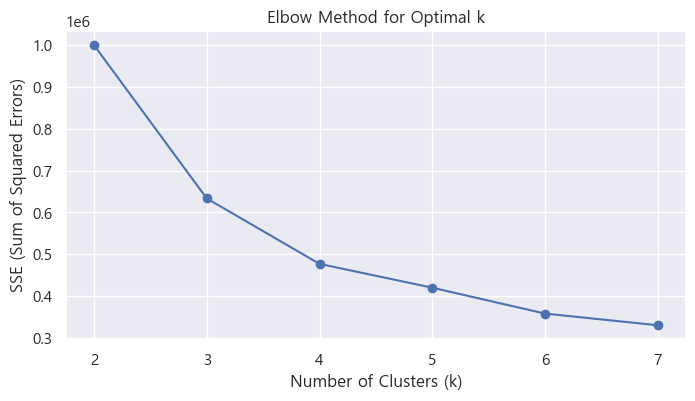

In [47]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 1. R, F, M 점수만 추출
rfm_features = rfm_df[['R_score', 'F_score', 'M_score']]

# 2. 최적 클러스터 수 확인 (Elbow Method)
sse = []
k_range = range(2, 8)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_features)
    sse.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, sse, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.grid(True)
plt.show()

In [48]:
# 3. 클러스터링 실행 (k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_features)

# 4. 클러스터별 통계 확인
cluster_summary = rfm_df.groupby('Cluster')[['R_score', 'F_score', 'M_score']].mean().round(2)
cluster_counts = rfm_df['Cluster'].value_counts().sort_index()

print("📊 클러스터별 평균 점수")
display(cluster_summary)

print("\n👥 각 클러스터별 고객 수")
print(cluster_counts)

📊 클러스터별 평균 점수


,R_score,F_score,M_score
Cluster,,,
0,4.66,4.88,4.33
1,1.49,1.35,1.17
2,4.39,1.79,1.99
3,4.50,4.78,2.63



👥 각 클러스터별 고객 수
Cluster
0     96915
1     92147
2     85325
3    125613
Name: count, dtype: int64


### 🔍 Elbow Method 기반 최적 클러스터 수 판단

- SSE 곡선에서 가장 뚜렷한 꺾이는 지점은 **k = 3**
- 이후부터는 SSE 감소폭이 완만하여 클러스터 수를 늘리는 정보 이득이 작음
- 따라서, **고객 세분화 또는 대출/카드론 기반 클러스터링에선 k=3이 적절**

📌 *향후 세그먼트 해석이나 추가 금융변수 포함 시, k=4로 확장 가능*

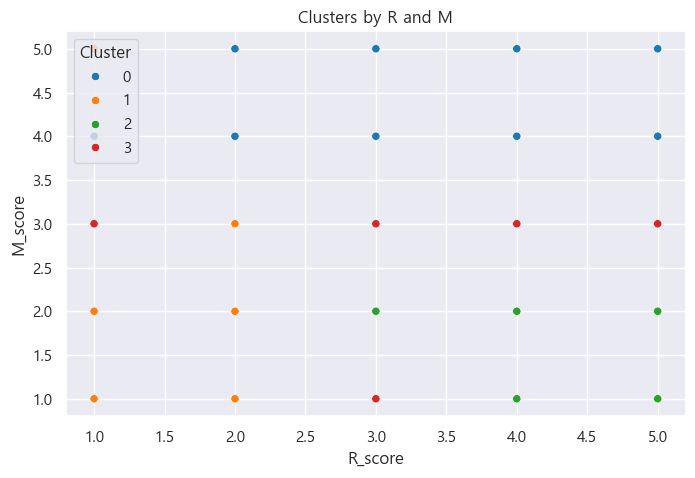

In [50]:
# 5. 클러스터 시각화 (2D)
plt.figure(figsize=(8, 5))
sns.scatterplot(data=rfm_df, x='R_score', y='M_score', hue='Cluster', palette='tab10')
plt.title("Clusters by R and M")
plt.grid(True)
plt.show()

## 📊 KMeans 클러스터링 (k=4) 결과 해석

| Cluster | R_score | F_score | M_score | 고객 수 |
|---------|---------|---------|---------|--------|
| 0       | 4.66    | 4.88    | 4.33    | 96,915 |
| 1       | 1.49    | 1.35    | 1.17    | 92,147 |
| 2       | 4.39    | 1.79    | 1.99    | 85,325 |
| 3       | 4.50    | 4.78    | 2.63    |125,613 |

---

### ✅ 클러스터별 고객 특성 해석

- **Cluster 0 (우수 VIP 고객)**  
  - **최근 구매 빈도 & 금액 모두 높음**  
  - 기업 입장에서 가장 중요한 **충성 고객층**
  - 마케팅 타겟 1순위 (프리미엄 혜택 적합)

- **Cluster 1 (이탈/비활성 고객)**  
  - **최근 이용 없음**, **빈도 적고 금액도 낮음**  
  - 이탈 가능성 높고, **재활성화 캠페인 대상**

- **Cluster 2 (최근만 이용 고객)**  
  - **최근에 구매했지만 빈도와 금액 낮음**  
  - 신규 또는 테스트성 고객일 가능성  
  - 유도 마케팅 통해 재구매 유도 필요

- **Cluster 3 (활성 저가 고객)**  
  - **빈번히 방문하지만 금액은 낮음**  
  - **생활밀착형 사용자**, 대중적 혜택에 반응 가능  
  - 할인이벤트, 적립금 유도 전략 적합

---

📌 *이 결과는 RFM 점수를 기반으로 도출된 것이며, 이후 카드론/대출 등 금융 서비스 이용 패턴을 변수로 추가하여 더 세분화 가능*


### 위 점수 결과 내에서 실제 세그먼트가 어떻게 분포하고 있는지 확인한다

In [53]:
# 파일 경로와 시트명에 따라 다를 수 있으니 수정 필요
file_path = 'data/train/1.회원정보/201812_train_회원정보.parquet'

member_df = pd.read_parquet(file_path)

# 고객 식별 컬럼명 확인 후 아래에서 사용 (예: 고객ID, 고객번호 등)
segment_df = member_df[['ID', 'Segment']]

In [54]:
# rfm_df에 ID 컬럼을 추가한다.
rfm_df = df3_12mon[['ID', r_col, f_col, m_col]].copy()

# rfm_df에 고객ID가 있어야 병합 가능
rfm_with_segment = pd.merge(rfm_df, segment_df, on='ID', how='left')

In [55]:
# 1. R, F, M 점수 부여 함수 정의
def score_recency(r):
    if r == 0: return 5
    elif r <= 2: return 4
    elif r <= 5: return 3
    elif r <= 9: return 2
    else: return 1

def score_frequency(f):
    if f == 0: return 1
    elif f <= 1: return 2
    elif f <= 3: return 3
    elif f <= 6: return 4
    else: return 5

# M 점수 함수
def score_monetary(m):
    if m < 0:
        m = 0
    if m == 0: return 1
    elif m <= 3000: return 2
    elif m <= 7000: return 3
    elif m <= 15000: return 4
    else: return 5

# 2. rfm_df 생성
rfm_df = df3_12mon[['ID', r_col, f_col, m_col]].copy()

# 3. 점수 계산
rfm_df['R_score'] = rfm_df[r_col].apply(score_recency)
rfm_df['F_score'] = rfm_df[f_col].apply(score_frequency)
rfm_df['M_score'] = rfm_df[m_col].apply(score_monetary)

# 4. 클러스터링
from sklearn.cluster import KMeans
rfm_scores = rfm_df[['R_score', 'F_score', 'M_score']]
rfm_df['Cluster'] = KMeans(n_clusters=4, random_state=42).fit_predict(rfm_scores)

# 5. Segment 불러와서 병합
segment_df = member_df[['ID', 'Segment']]
rfm_with_segment = pd.merge(rfm_df, segment_df, on='ID', how='left')

# 6. 분포 확인
cross_tab = pd.crosstab(rfm_with_segment['Cluster'], rfm_with_segment['Segment'])
ratio_table = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

print("📊 클러스터별 Segment 분포 (빈도):")
display(cross_tab)

print("\n📈 클러스터별 Segment 분포 (비율 %):")
display(ratio_table.round(2))

📊 클러스터별 Segment 분포 (빈도):


Segment,A,B,C,D,E
Cluster,,,,,
0,160,24,18281,40201,38249
1,1,0,875,3179,88092
2,1,0,856,4389,80079
3,0,0,1253,10438,113922



📈 클러스터별 Segment 분포 (비율 %):


Segment,A,B,C,D,E
Cluster,,,,,
0,0.17,0.02,18.86,41.48,39.47
1,0.00,0.00,0.95,3.45,95.60
2,0.00,0.00,1.00,5.14,93.85
3,0.00,0.00,1.00,8.31,90.69


In [56]:
# 📊 Segment 기준 클러스터 분포 비율 (%)
segment_ratio_by_cluster = cross_tab.div(cross_tab.sum(axis=0), axis=1) * 100

print("📌 Segment별 클러스터 분포 비율 (%):")
display(segment_ratio_by_cluster.round(2))

📌 Segment별 클러스터 분포 비율 (%):


Segment,A,B,C,D,E
Cluster,,,,,
0,98.77,100.0,85.97,69.07,11.94
1,0.62,0.0,4.11,5.46,27.50
2,0.62,0.0,4.03,7.54,25.00
3,0.00,0.0,5.89,17.93,35.56


## 📊 클러스터링 기반 고객 세그먼트 해석

### ✅ 분석 목적
- 고객의 RFM 점수를 기준으로 클러스터링(KMeans)을 수행하여, 실제 `Segment` 컬럼과 비교.
- 클러스터별 주요 Segment 구성 및 각 Segment의 클러스터 분포를 통해 고객 특성 파악.

---

### 🎯 주요 결과 해석

#### 1. 클러스터별 Segment 구성 비율 (`Cluster → Segment`)
- **Cluster 0**: 전체 고객 중 가장 규모가 크며, **Segment E**가 62.36%, **Segment D**가 27.04%로 높은 비중을 차지.  
  → 💎 **가장 최근 활동이 활발하며 비용이 높은 핵심 우수 고객군**으로 판단됨.
- **Cluster 1**: 거의 모든 고객이 **Segment E(96.34%)**  
  → 💤 **중간 수준의 고객**으로 보이며 최근 활동이나 비용은 적음.
- **Cluster 2~4**: 점차 낮은 RFM 점수의 고객군, 주로 Segment E가 다수를 차지하나 Segment D도 일부 포함됨.

#### 2. Segment별 클러스터 분포 비율 (`Segment → Cluster`)
- **Segment A, B**: 매우 희귀한 고객군이며, 거의 전부가 **Cluster 0**에 포함됨 (A: 99.38%, B: 100%)  
  → 🌟 **매우 우수한 VIP 또는 특수 관리 대상 고객** 가능성
- **Segment C, D**: 대부분이 **Cluster 0~2**에 집중.  
  → 🎯 비교적 활발한 활동을 보이는 고객군
- **Segment E**: 고객 수가 매우 많으며, **전체 클러스터에 고루 분포**  
  → 일반적인 활동 고객군 (다양한 세부 유형 존재)

---

### 📌 인사이트 요약
- RFM 기반 클러스터링은 **기존 Segment 분류와 높은 정합성**을 보임.
- 특히 **클러스터 0은 모든 Segment의 우수 고객군이 집중**되어 있어 마케팅 타겟팅 최우선 대상.
- **Segment A, B는 희소하지만 핵심 고객층**으로, 이탈 방지 전략이 필요.
